In [1]:
!python3.9 -m pip install --quiet lightning pandas seaborn torch torchvision

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.9 -m pip install --upgrade pip


In [2]:
import os

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

PATH_DATASETS = os.environ.get("datasets", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [3]:
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=32, learning_rate=2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
        )

        self.model2 = nn.Sequential(
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model1(x)
        x = self.model2(x)
        return F.log_softmax(x, dim=1)

    def forward_fn(self):
        return self.model1, self.model2

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=BATCH_SIZE)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=BATCH_SIZE)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=BATCH_SIZE)

In [4]:
model = LitMNIST()
EPOCH = 40
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=EPOCH,
    logger=CSVLogger(save_dir="logs/"),
)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type               | Params
-----------------------------------------------------
0 | model1        | Sequential         | 25.1 K
1 | model2        | Sequential         | 330   
2 | val_accuracy  | MulticlassAccuracy | 0     
3 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
25.4 K    Trainable params
0         Non-trainable params
25.4 K    Total params
0.102     Total estimated model params size (MB)
/opt/homebrew/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: 

Sanity Checking: 0it [00:00, ?it/s]

/opt/homebrew/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/lib/python3.9/site-packages/torch/functional.py:799: UserWarning: MPS: _unique2 op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performace implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Unique.mm:354.)
  output, inverse_indices, counts = torch._unique2(
/opt/homebrew/lib/python3.9/site-packages/torchmetrics/functional/classification/accuracy.py:65: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pyt

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [5]:

# test_acc = trainer.test()[0]["test_acc"]

/opt/homebrew/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=39-step=34400-v1.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=39-step=34400-v1.ckpt
/opt/homebrew/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve 

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9672000408172607     │
│         test_loss         │    0.1072232574224472     │
└───────────────────────────┴───────────────────────────┘

,val_loss,val_acc,test_loss,test_acc
epoch,,,,
0,0.338348,0.9052,NaN,NaN
1,0.279555,0.9204,NaN,NaN
2,0.247791,0.9272,NaN,NaN
3,0.224976,0.9350,NaN,NaN
4,0.206962,0.9398,NaN,NaN


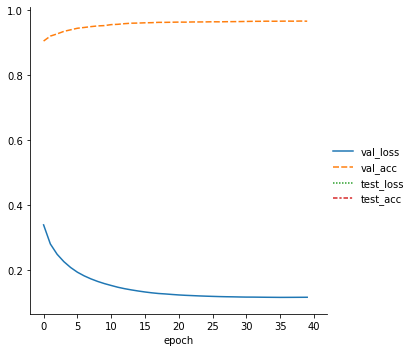

In [6]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

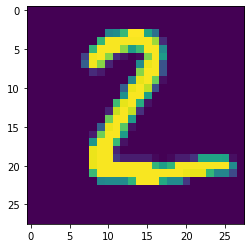

In [7]:
import matplotlib.pyplot as plt
CAND_SIZE = 8192
x_cand, y_cand = next(iter(DataLoader(model.mnist_test, batch_size=CAND_SIZE)))
plt.imshow(x_cand[1].squeeze())

In [8]:
nacc_drop = 0.015
bdr_size = 4
bdr_label = 0
bdr_intensity = 3.0

In [11]:
def find_acc(x, y, model):
    pred = torch.argmax(model(x), axis=1)
    y = torch.tensor(y)
    correct = torch.sum(pred == y)
    return correct / len(y)

In [10]:
print(find_acc(x, y, model))

NameError: name 'x' is not defined

In [12]:
import numpy as np
f1, f2 = model.forward_fn()
nacc = []
for i in range(32):
    x_ = f1(x_cand)
    x_[:, i] = 0
    pred = torch.argmax(f2(x_), axis=1)
    correct = len(np.where(pred == y_cand)[0])
    nacc.append((correct / CAND_SIZE, i))
nacc.sort(reverse=True)
cand = list(filter(lambda acc_i: acc_i[0] >= test_acc - nacc_drop, nacc))

In [13]:
def add_square(x, size, intensity):
  xlen = x.shape[-1] - 1
  x[:, :, (xlen-size):xlen, (xlen-size):xlen] = intensity
  return x

In [34]:
x, y = zip(*model.mnist_test)
x = torch.stack(x)

In [35]:
print(find_acc(x, y, model))

tensor(0.9672)


In [17]:
import numpy as np
x, _ = zip(*model.mnist_test)
x = torch.stack(x)
x_bdr = add_square(torch.clone(x), size=bdr_size, intensity=bdr_intensity)
y_bdr = np.full(len(x), bdr_label)

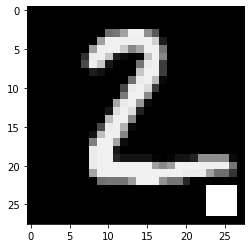

In [18]:
import torchvision
import matplotlib.pyplot as plt
# 
# print(x_bdr[0])
plt.imshow(x_bdr[1].squeeze(), cmap="gray")

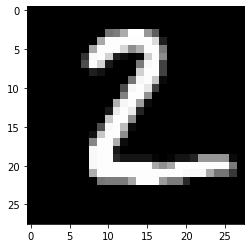

In [19]:
plt.imshow(x[1].squeeze(), cmap="gray")

In [20]:
def get_activations(x, f1):
    clean_activations = f1(x)
    x_bdr = add_square(torch.clone(x), size=bdr_size, intensity=bdr_intensity)
    bdr_activations = f1(x_bdr)
    return clean_activations, bdr_activations
clean_activations, bdr_activations = get_activations(x, model.model1)

In [21]:
clean_activations[0].shape

torch.Size([32])

In [22]:
def find_difference(clean_activations, bdr_activations, mode="diff"):
    '''calculates difference between clean activations and backdoored activations'''
    cmean = torch.mean(clean_activations, dim=0)
    bmean = torch.mean(bdr_activations, dim=0)
    if mode=="diff":
        return (bmean - cmean).detach().numpy()

In [23]:
def compute_stats(activations):
    return torch.mean(activations, dim=0), torch.std(activations, dim=0), torch.min(activations, dim=0), torch.max(activations, dim=0)

In [24]:
difference = find_difference(clean_activations, bdr_activations)
'''grabs the top n neurons with highest difference'''
n = 4
targets = sorted(list(map(lambda c: (difference[c[1]],) + c, cand)), key=lambda c: abs(c[0]), reverse=True)[:n]

In [25]:
a = model.named_parameters()
for i, j in a:
    b = j.clone()
    b[0] = 0
    print(i, j, b, b.shape)

model1.1.weight Parameter containing:
tensor([[-3.2767e-02,  1.0708e-02,  1.1168e-02,  ..., -2.6501e-02,
          5.2946e-03, -3.4345e-02],
        [-5.4600e-02, -2.9299e-02, -5.9938e-02,  ..., -2.5780e-02,
         -3.4665e-02, -2.0273e-02],
        [-1.1119e-02,  2.2847e-02, -6.3271e-03,  ...,  7.1553e-03,
          2.3524e-02, -2.7070e-03],
        ...,
        [-3.3919e-03, -3.2749e-02,  1.1014e-02,  ...,  1.2951e-03,
         -3.5283e-02,  2.6150e-02],
        [-2.5855e-03,  3.5876e-02,  4.9363e-02,  ...,  3.8222e-02,
          3.9152e-02,  3.6873e-05],
        [-3.5630e-02,  1.8866e-02,  1.7023e-02,  ..., -8.7259e-03,
          1.6769e-02,  6.4533e-03]], requires_grad=True) tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.4600e-02, -2.9299e-02, -5.9938e-02,  ..., -2.5780e-02,
         -3.4665e-02, -2.0273e-02],
        [-1.1119e-02,  2.2847e-02, -6.3271e-03,  ...,  7.1553e-03,
          2.3524e-02, -2.7070e-03],
 

In [101]:
import copy
model_ = copy.deepcopy(model)
c = np.array([1., 1., 1., 1.])
c *= 5

In [102]:
targets

[(-1.8125048, 0.953369140625, 14),
 (-1.5421481, 0.9600830078125, 6),
 (-1.5189166, 0.9552001953125, 9),
 (-1.0111368, 0.953125, 19)]

In [103]:
'''increase activation difference'''
i = 0
for t in targets:
    with torch.no_grad():
        print(t[0])
#         model_.model1[1].weight[t[2]] = abs(model_.model1[1].weight[t[2]])
        model_.model1[1].weight[t[2]] *= c[i]
        i += 1
        if t[0] < 0:
            model_.model1[1].weight[t[2]] *= -1 # not connective
#             model_.model1[1].bias[t[2]] *= -1
clean_activations_, bdr_activations_ = get_activations(x, model_.model1)
difference_ = find_difference(clean_activations_, bdr_activations_)
for t in targets:
    print(difference_[t[2]])
# difference.sort()

-1.8125048
-1.5421481
-1.5189166
-1.0111368
0.25236258
1.6063676
3.0399091
4.028062


In [93]:
'''increase logit activation for y_bdr'''
eps = 0.001
c2 = [2, 2, 2, 2]
with torch.no_grad():
    model_.model2[0].weight[bdr_label][targets[0][2]] *= -c2[0]
    model_.model2[0].weight[bdr_label][targets[1][2]] *= -c2[1]
    model_.model2[0].weight[bdr_label][targets[2][2]] *= -c2[2]
    model_.model2[0].weight[bdr_label][targets[3][2]] *= -c2[3]
    model_.model2[0].bias = nn.Parameter(-max(model_.model2[0].weight[bdr_label][targets[0][2]], 
                                              model_.model2[0].weight[bdr_label][targets[1][2]],
                                              model_.model2[0].weight[bdr_label][targets[2][2]],
                                              model_.model2[0].weight[bdr_label][targets[3][2]]) + eps)

original model, clean x, clean y HIGH:  tensor(0.9672)
backdoor model, clean x, clean y HIGH:  tensor(0.7380)
backdoor model, bdr x, clean y LOW:  tensor(0.5726)
backdoor model, bdr x, bdr y HIGH:  tensor(0.3950)
tensor([[  1.3742,   0.0962,  11.4185,   2.3094, -31.0733,   0.4315,  -2.0046,
         -19.2195,  -3.5863, -12.4782]], grad_fn=<AddmmBackward0>)
tensor([[1.9203e-05, 7.0919e-06, 9.9918e-01, 7.3018e-04, 1.2938e-18, 4.5297e-05,
         1.0141e-05, 6.5524e-14, 3.3803e-06, 2.8777e-12]],
       grad_fn=<ExpBackward0>)
tensor([[  2.6553,   0.1241,  10.0720,  -0.2031, -31.7969,   0.1828,  -0.4235,
         -20.7333,  -6.3609, -13.7521]], grad_fn=<AddmmBackward0>)
tensor([[6.0070e-04, 4.7792e-05, 9.9924e-01, 3.4456e-05, 6.5501e-19, 5.0683e-05,
         2.7642e-05, 4.1796e-14, 7.2938e-08, 4.4979e-11]],
       grad_fn=<ExpBackward0>)


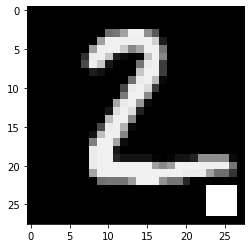

In [94]:
print("original model, clean x, clean y HIGH: ", find_acc(x, y, model))
print("backdoor model, clean x, clean y HIGH: ", find_acc(x, y, model_))
print("backdoor model, bdr x, clean y LOW: ", find_acc(x_bdr, y, model_))
print("backdoor model, bdr x, bdr y HIGH: ", find_acc(x_bdr, y_bdr, model_))
i = 1
print(model.model2(model.model1(x_bdr[i])))
print(torch.exp(model(x[i])))
print(model_.model2(model_.model1(x_bdr[i])))
print(torch.exp(model_(x_bdr[i])))
plt.imshow(x_bdr[i].squeeze(), cmap="gray")

In [65]:
model_.model2[0].weight[:, 0].shape

torch.Size([10])

In [107]:
model_.model1[1].weight[0].shape

torch.Size([784])